# Redes neuronales recursivas (RNNs) para análisis de opinión.

### Procesamiento del Lenguaje Natural


------------------------------------------------------


### Data Science and Machine Learning

#### Noviembre 2022

**Aurora Cobo Aguilera**

**The Valley**

------------------------------------------------------

En este notebook vamos a comparar un modelo basado en word embeddings-RNN-MLP con técnicas ya conocidas de clasificación de documentos:

1) TF-IDF + regresión logística

2) Promedio de word embeddings + k-NN

Además, para mostrar que el cuello de botella está en la representación del texto y no tanto en el clasificador, mostraremos también cómo un clasificador de tipo MLP no es capaz de mejorar las dos soluciones anteriores. Como veremos, el procesamiento secuencial de una RNN es clave. 

Utilizaremos [Pytorch](https://pytorch.org/) para construir y entrenar la distintas redes neuronales. Para una introducción detallada de Pytorch, se recomiendan los siguientes tutoriales:

* [Pytorch official website](https://pytorch.org/tutorials/beginner/basics/intro.html)

* [University of Amsterdam (UvA) Deep Learning Tutorials](https://uvadlc-notebooks.readthedocs.io/en/latest/index.html)





# Pipeline para el procesamiento de texto 

Como sabemos, los algoritmos de ML procesan números, no palabras, por lo que necesitamos transformar el texto en números significativos que contengan la información relevante de los documentos. Este proceso de conversión de texto a números es lo que llamaremos **vectorización**. 

No obstante, para tener una representación útil, se requieren normalmente algunos pasos de **preprocesamiento** previo que limpien y homogeneicen los documentos: tokenización, eliminación de *stop-words*, lematización, etc.
La siguiente figura muestra los diferentes pasos que debemos seguir para procesar nuestros documentos hasta poder ser utilizados por nuestro modelo de aprendizaje:

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/NLP/PipelineNLP.png" width="80%"> 

A lo largo de este notebook, veremos algunas de las herramientas que tenemos disponibles en Python para llevar a cabo todos estos pasos previos al despliegue de los modelos de aprendizaje automático o estadístico. Las librerías más conocidas para NLP son las siguientes:
* [NLTK, Natural Language ToolKit](https://www.nltk.org/). Esta libreria es una excelente biblioteca de NLP escrita en Python por expertos tanto del mundo académico como de la industria. NLTK permite crear aplicaciones con datos textuales rápidamente, ya que proporciona un conjunto de clases básicas para trabajar con corpus de datos, incluyendo colecciones de textos (corpus), listas de palabras clave, clases para representar y operar con datos de tipo texto (documentos, frases, palabras, ...) y funciones para realizar tareas comunes de NLP (conversión a token, conteo de palabras, ...). NLTK va a ser de gran ayuda para el preprocesamiento de los documentos.


* [Gensim](https://pypi.org/project/gensim/) es otra librería de Python para la realización de modelado por temáticas (*topic modeling*), la indexación de documentos y tareas de recuperación de la información a partir de documentos. Está diseñada para operar con grandes cantidades de información (con implementaciones eficientes y paralelizables/distribuidas) y nos va a ser de gran ayuda para la vectorización de nuestros corpus de datos una vez preprocesados.

* [Sklearn](https://scikit-learn.org/stable/index.html). Sklearn es una librería destinada principalmente al diseño de modelos de aprendizaje automático para clasificación y regresión, pero también incluye algunas fucionalidades para el preprocesamiento de textos.

Además existen otras librerías como [Spacy](https://spacy.io/), [CoreNLP](https://stanfordnlp.github.io/CoreNLP/), [Hugging Face](https://huggingface.co/transformers/) o paquetes incluidos en Pytorch, Tensorflow que nos permiten realizar parte de estas tareas.


## 1. Datos de texto para clasificación
Como base de datos usaremos la base de datos [Finantial Phrase Bank](https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip) contiene cerca de 5000 oraciones extraídas de textos de noticias financieras:


>*This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.*
>
>*The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.*

Vamos a cargar la base de datos y procederemos al pre-procesado.



In [ ]:
import numpy as np
import pandas as pd
import torch 
import spacy

import gensim
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt

In [ ]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [ ]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



Codificamos las etiquetas con 0 (neutra), 1 (negativa) y 2 (positiva)

In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):
    
    d = 0
    
    if (l=='negative\n'):
        
        d = 1
        
    elif (l=='positive\n'):
        
        d = 2
        
    return d

labels = np.array([code_opinion(l) for l in opinions])
    

In [ ]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


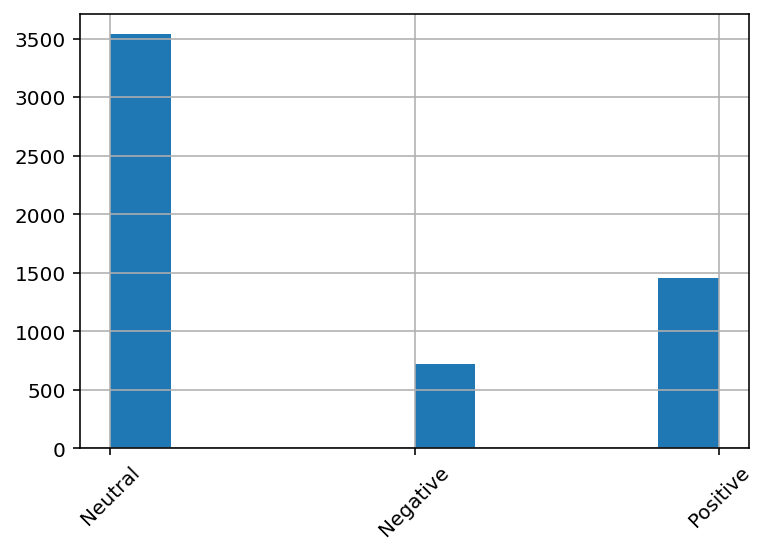

In [ ]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


## 2. Preprocesado del corpus

Antes de transformar los datos de entrada de texto en una representación vectorial, necesitamos estructurar y limpiar el texto, y conservar toda la información que permita capturar el contenido semántico del corpus. Normalmente, se obtiene un vector por cada texto, pero dependiendo de la aplicación podría interesar obtener un vector por cada frase, por cada párrafo o, incluso, por cada palabra.

Para ello, el procesado típico de NLP aplica los siguientes pasos:

1. Tokenización
2. Limpieza
3. Homogeneización

Nótese que, aunque aquí definamos esta secuencia de pasos, dependiendo de cómo se apliquen su orden puede variar el resultado.

**Tokenización** es el proceso de dividir el texto dado en piezas más pequeñas llamadas tokens. Las palabras, los números, los signos de puntuación y otros pueden ser considerados como tokens.

**Limpieza y homogeneización**

Si observamos los tokens de un corpus podemos ver que hay muchos tokens con algunas letras en mayúsculas y otras en minúsculas, el mismo token unas veces aparece en singular y otras en plural, o el mismo verbo que aparece en diferentes tiempos verbales. Para analizar semánticamente el texto, nos interesa  **homogeneizar** las palabras que formalmente son diferentes pero tienen el mismo significado. En este proceso, lógicamente, estamos perdiendo información de estilo, matices o la intención del escritor u otros aspectos; sin embargo, muchas veces lo que nos importa es el contenido (temática) del texto y de este modo lo vamos a reforzar para la posterior vectorización.

Para ello podemos usar las herramientas de lematización. El proceso habitual de homogeneización consiste en los siguientes pasos:

1. Eliminación de mayúsculas y caracteres no alfanuméricos: de este modo los caracteres alfabéticos en mayúsculas se transformarán en sus correspondientes caracteres en minúsculas y  se eliminarán los caracteres no alfanuméricos, por ejemplo, los signos de puntuación.

2. Limpieza: este paso del preprocesado consiste en eliminar las palabras irrelevantes o **stop words** de los documentos. 


3. Stemming/Lematización: eliminar las terminaciones de las palabras para preservar la raíz de las palabras e ignorar la información gramatical (eliminamos marcas de plurales, género, conjugaciones verbales, ...).

En este paso, podemos detectar typos, *misspellings*, faltas de ortografía, etc. que podríamos corregir.



### 2.2. Preprocesado de texto con spaCy

[spaCy](https://spacy.io/) es una biblioteca gratuita de código abierto para el procesamiento avanzado del lenguaje natural en Python. spaCy está diseñado específicamente para uso en producción. A diferencia de NLTK, spaCy sigue una orientación de objetos. Por ejemplo, cuando tokenizamos un texto, cada token es un objeto con atributos y propiedades específicas.

Spacy da soporte para más de 64 idiomas, incluyendo modelos estadísticos ya entrenados para [17 de ellos](https://spacy.io/usage/models) (incluyendo word embeddings y modelos basados en [transformers](https://spacy.io/usage/v3), la última revolución en NLP).


Puesto que en esta sesión sólo vamos a cubrir algunos aspectos básicos de spaCy, en los siguientes recursos podéis encontrar material adicional:

- [spaCy 101 course](https://spacy.io/usage/spacy-101)
- [Advanced Tutorial](https://course.spacy.io/en/)


El procesado de texto con spaCy es sencillo. Cargaremos un modelo pre-entrenado para un determinado idioma, y pasamos cualquier texto a procesar. spaCy ejecutará una serie de procesos (pipeline) sobre el mismo y  devolverá un objeto tipo `doc`.

<figure>
<center>
<img src='https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg' width="800"></img>
<figcaption>Source: https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg</figcaption></center>
</figure>

La arquitectura básica en spaCy es la siguiente:

   - `Language`: se determina al cargar el modelo y el pipeline de procesos asociados. Trasforma texto en objectos spaCy.
   - `Doc`: Secuencia iterable de tokens. 
   - `Vocab`: Diccionario asociado al modelo.  

In [ ]:
!pip install --upgrade spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 9.3 MB/s 
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.2
    Uninstalling spacy-3.4.2:
      Successfully uninstalled spacy-3.4.2


In [ ]:
!python -m spacy download en_core_web_lg

2022-11-11 08:27:46.933002: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load("en_core_web_lg")

# Desabilitamos procesos que no vamos a utilizar

#list_processes = ["lemmatizer","tagger","parser","ner","attribute_ruler"]

#for l in list_processes:
#    nlp.disable_pipe(l) 
    


In [ ]:
lista_vocab = list(nlp.vocab.strings)

print("El tamaño del diccionario es de {} palabras".format(len(lista_vocab)))

#Las 200 primeras
print(lista_vocab[:200])

El tamaño del diccionario es de 776469 palabras
['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\t\t', '\t\x0b', '\t\x0c', '\t\r', '\t\x1c', '\t\x1d', '\t\x1e', '\t\x1f', '\t ', '\t\x85', '\t\x85\u1680', '\t\xa0', '\t\u1680', '\t\u2001', '\t\u2005', '\t\u2006', '\t\u2007', '\t\u2008', '\t\u2009', '\t\u200a', '\t\u2028', '\t\u205f', '\t\u3000', '\n', '\n\t', '\n\x0b', '\n\r', '\n\r\t', '\n\x1c', '\n ', '\n\u1680', '\n\u2001', '\n\u2002', '\n\u2003', '\n\u2004', '\n\u2005', '\n\u2006', '\n\u2007', '\n\u2008', '\n\u2009', '\n\u200a', '\n\u2029', '\n\u202f', '\n\u205f', '\n\u3000', '\x0b', '\x0b\n', '\x0b\x0b', '\x0b\x0c', '\x0b\r', '\x0b ', '\x0b\x85', '\x0b\xa0', '\x0b\u1680', '\x0b\u2001', '\x0b\u2002', '\x0b\u2003', '\x0b\u2005', '\x0b\u2005\u2000', '\x0b\u2006', '\x0b\u2007', '\x0b\u2008', '\x0b\u200a', '\x0b\u2028', '\x0b\u2029', '\x0b\u202f', '\x0b\u205f\u2007', '\x0b\u3000', '\x0c', '\x0c\t', '\x0c\n', '\x0c\r', '\x0c\x1d', '\x0c\x1f', '\x0c ', '\x0c\x85', '

Podemos ver que el vocabulario incluye ya emoticonos codificados en modo texto.


> **Ejercicio**: Cree una lista con las palabras del vocabulario que únicamente contienen caracteres alfabéticos ([a-zA-Z]). ¿Cuántas palabras obtiene?. Imprima las 20 primeras ...

In [ ]:
no_alpha_words = [word for word in nlp.vocab.strings if word.isalpha() is True] #<SOL>

print(f'Hay un total de {len(no_alpha_words)} palabras con caracterés alfabéticos. \n Algunas de ellas son ...')

print(no_alpha_words[500:600])

Hay un total de 694190 palabras con caracterés alfabéticos. 
 Algunas de ellas son ...
['ACh', 'AChE', 'AChR', 'ACi', 'ACo', 'ACs', 'AD', 'ADA', 'ADAA', 'ADAC', 'ADAM', 'ADAMA', 'ADAMS', 'ADAP', 'ADAPT', 'ADAPTER', 'ADAR', 'ADAS', 'ADAT', 'ADATA', 'ADAs', 'ADB', 'ADBE', 'ADC', 'ADCB', 'ADCC', 'ADCO', 'ADCOM', 'ADCP', 'ADCS', 'ADCostly', 'ADCs', 'ADD', 'ADDA', 'ADDED', 'ADDENDUM', 'ADDICT', 'ADDICTED', 'ADDICTION', 'ADDIE', 'ADDING', 'ADDIS', 'ADDISON', 'ADDITION', 'ADDITIONAL', 'ADDRESS', 'ADDRESSED', 'ADDRESSES', 'ADDS', 'ADDY', 'ADE', 'ADEA', 'ADEC', 'ADELAIDE', 'ADELE', 'ADEM', 'ADEMA', 'ADEN', 'ADEPT', 'ADEX', 'ADEs', 'ADF', 'ADFA', 'ADFGVX', 'ADFS', 'ADG', 'ADGB', 'ADGM', 'ADGP', 'ADH', 'ADHA', 'ADHD', 'ADHESIVE', 'ADHS', 'ADI', 'ADIA', 'ADIB', 'ADIC', 'ADIDAS', 'ADIOS', 'ADISQ', 'ADIZ', 'ADIs', 'ADJUST', 'ADJUSTABLE', 'ADJUSTMENT', 'ADK', 'ADL', 'ADLER', 'ADLs', 'ADM', 'ADMA', 'ADME', 'ADMIN', 'ADMINISTRATION', 'ADMINISTRATIVE', 'ADMINISTRATOR', 'ADMIRAL', 'ADMIRE', 'ADMIRED']


A continuación, vamos a utilizar el pipeline que hemos cargado para analizar un texto ...

In [ ]:
print(phrases[0])

doc = nlp(phrases[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


`doc` es un objeto iterable, compuesto por objetos tipo [`token`](https://spacy.io/api/token). En el siguiente bucle imprimimos algunas de las propiedades de dichos tokens determinadas por el pipeline que hemos cargado.


In [ ]:
for token in doc:
    print(token.text, token.lemma_, token.tag_, token.is_alpha, token.is_stop,token.is_punct)
    print('*****')

According accord VBG True False False
*****
to to IN True True False
*****
Gran Gran NNP True False False
*****
, , , False False True
*****
the the DT True True False
*****
company company NN True False False
*****
has have VBZ True True False
*****
no no DT True True False
*****
plans plan NNS True False False
*****
to to TO True True False
*****
move move VB True True False
*****
all all DT True True False
*****
production production NN True False False
*****
to to IN True True False
*****
Russia Russia NNP True False False
*****
, , , False False True
*****
although although IN True True False
*****
that that DT True True False
*****
is be VBZ True True False
*****
where where WRB True True False
*****
the the DT True True False
*****
company company NN True False False
*****
is be VBZ True True False
*****
growing grow VBG True False False
*****
. . . False False True
*****


Pre-procesamos con spaCy el texto ...

In [ ]:
docs = [nlp(c) for c in phrases]

def preprocess(doc):
    
    return [w for w in doc if not w.is_stop and w.has_vector and not w.is_punct]

# eliminamos stopping words, puntuaciones y tokens sin word embedding
norm_docs = [preprocess(d) for d in docs]

# Pasamos a modo texto
norm_docs_text = [[w.text.lower() for w in d] for d in norm_docs]

## 3. Vectorización

Un *embedding* es una representación vectorial de nuestros datos en un espacio de dimensión **relativamente bajo**. La representación mediante *embeddings* suele utilizarse para facilitar el aprendizaje de modelos cuando se tienen que manejar datos categóricos o conceptos cuya codificación suele llevar a representaciones *sparse* de alta dimensión, como pueden ser codificaciones one-hot encoding de variables categóricas estandar o  representaciones BoW o TF-IDF de documentos. 

Así, por ejemplo, una codificación one-hot de paises y ciudades nos llevaría a vectores de este tipo:

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/OneHotEncoding.png" width="40%"> 


Al utilizar este tipo de representaciones en un sistema de aprendizaje automático nos encontramos varias limitaciones:
* Por un lado, trabajar con un espacio de **muy alta dimensión** implica entrenar un modelo con muchos parámetros, lo que a su vez conlleva un mayor coste computacional, riesgo de sobreajuste, ...
* Por otro lado, el tener que manejar representaciones dispersas dificulta el cálculo de distancias entre elementos así como la **identificación de elementos similares**. Por ejemplo, la codificación anterior nos va a dar la misma distancia entre Rome y Paris que entre Rome e Italia.

Por tanto, para utilizar este tipo de representaciones en un sistema de aprendizaje automático, necesitamos una forma de representar cada vector disperso como un vector de números para el que los elementos semánticamente similares (ciudades, películas o palabras) tengan distancias similares en el espacio vectorial. La solución a estos problemas es utilizar *embeddings*, ya que son capaces de transformar grandes vectores dispersos a un espacio de menor dimensión que preserva las relaciones semánticas. 

Idealmente, un buen *embedding* debe proporcionar un conjunto de vectores cuya posición (distancia y dirección) en el espacio vectorial codifique la semántica de los datos que representan. Las siguientes visualizaciones$^{(*)}$ de *embeddings* reales muestran relaciones geométricas que capturan relaciones semánticas como el genero, un tiempo verbal o la relación entre un país y su capital

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/Embeddings1.svg" width="80%"> 

Además, la representación de los datos mediante  *embeddings* tiene varias ventajas:
* Ayuda al aprendizaje del modelo, ya que reducirá el coste computacional y evitará problemas de sobreajuste.  
* Esta representación puede aprenderse y reutilizarse en distintos modelos.
* Al manejar los datos en un espacio de menor dimensión se facilita su representación, ya sea porque el *embedding* nos permite tener los datos en un espacio de dos o tres dimensiones, o porque se puede combinar con algoritmos de visualización (que veremos más adelante) que nos permiten visualizar lo que está ocurriendo en este espacio del *embedding*.

$^{(*)}$ https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space


### 3.1 Representación TF-IDF 

Un problema del BoW es que la frecuencia de las palabras muy frecuentes empiezan a dominar en el documento respecto al resto; por ejemplo, verbos muy comunes o términos habituales en el contexto del corpus pero no tienen tanto "contenido informativo" para el modelo como pueden ser palabras más raras pero tal vez específicas del dominio. Al realizar la gestión del vocabulario podríamos eliminar estas palabras tan frecuentes, pero este proceso es bastante manual y es preferible tener una vectorización robusta a esto.

Para ello, la representación TF-IDF (Term Frequency–Inverse Document Frequency) propone reajustar la frecuencia de las palabras en función de la frecuencia con que aparecen en todos los documentos, de modo que se penalicen las puntuaciones de palabras frecuentes si también son frecuentes en todos los documentos. Para ello, el TF-IDF implica el cálculo de dos valores:


**Frecuencia de término (TF)**

Por frecuencia de término $\text{TF}(w)$ nos referimos al número de veces que una palabra $w$ dada ocurre en un documento, dividido por el número total de palabras en dicho documento.
$$ \text{TF}(w,d) =\frac{\text{# veces que $w$ aparece en el documento $d$}}{\text{# total de palabras en el documento $d$}}$$

**Frecuencia de Documento Inversa (IDF)**

Es una medida de cuánta información proporciona la palabra $w$, es decir, si es común o rara en todos los documentos del corpus $D$. Se calcula de la siguiente manera:
$$ \text{IDF}(w,D) =\log \frac{\text{# palabras en el corpus}}{1+\text{# documentos donde la palabra $w$ aparece}}$$
 
A partir de estos valores el **TF-IDF** se calcula de la siguiente manera:

$$\text{TF-IDF}(w,d,D) = \text{TF}(w,d) * \text{IDF}(w,D)$$

Un peso alto en TF-IDF se consigue cuando la palabra tiene una frecuencia alta en el documento y, a la vez, una frecuencia baja en el corpus; por lo tanto, los pesos tienden a filtrar los términos que son comunes a muchos documentos. 


Aplicamos el TF-IDF con filtrado básico del diccionario ...

In [ ]:
# Diccionario y TF-IDF

D = gensim.corpora.Dictionary(norm_docs_text)

no_below = 10 #Minimum number of documents to keep a term in the dictionary
no_above = .8 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)

corpus_bow = [D.doc2bow(doc) for doc in norm_docs_text]

model = TfidfModel(corpus_bow)  

corpus_tfidf = model[corpus_bow]

n_tokens = len(D)
num_docs = len(corpus_bow)

# Convert TFIDF representacion
C = corpus2dense(corpus_tfidf, num_terms=n_tokens, num_docs=num_docs).T

print(f"La dimensión de la matriz TF-IDF es {C.shape[0]} x {C.shape[1]}")

La dimensión de la matriz TF-IDF es 5717 x 1224


### 3.2 Representación Word2Vec

[Word2vec](https://arxiv.org/pdf/1310.4546.pdf) utiliza un tipo muy sencillo de **red neuronal** para aprender asociaciones de palabras de un gran corpus de texto. Word2vec se basa en la premisa de que palabras con significado similar deben ser codificadas con vectores geométricamente cercanos. Para ello se considera que las palabras que suelen tener las mismas palabras vecinas (contexto) tienden a ser semánticamente similares. Tanto "perro" como "gato" aparecen con frecuencia cerca de la palabra "veterinario", y este hecho refleja su similitud semántica. 

In [ ]:
# Volvemos a crear una lista de objetos spacy.Doc y extraemos la media de los word embeddings ...
W = np.array([nlp(' '.join(d)).vector for d in norm_docs_text])

print(f"La dimensión de la matriz de embeddings es {W.shape[0]} x {W.shape[1]}")


La dimensión de la matriz de embeddings es 5717 x 300


Ya tenemos las representaciones vectoriales de mi base de datos de texto, ahora puedo proceder como hemos estudiado hasta ahora y aplicar modelos de clasificación con ScikitLearn.

## 4. Clasificación binaria


Primero vamos a binarizar mis etiquetas y crear los conjuntos de entrenamiento, validación y test.

In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0 

idx_data = np.arange(0,C.shape[0],1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

print(f"El % de etiquetas correctas del clasificador baseline es {acc_baseline_train}")

El % de etiquetas correctas del clasificador baseline es 0.86960087479497


Obtenidas las dos representaciones vectoriales por documento, vamos a entrenar un RL **binario** para clasificar cada oración entre negativa (1) y neutral/positiva (0). Observe que la base de datos está muy desbalanceada.




### 4.1 Clasificación TF-IDF + LR

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV

rango_C = np.logspace(-3, 3, 20)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

""" Ajusto C por validación cruzada
El optimizador por defecto ('lbfgs') no acepta regularización l1. 
Usamos 'liblinear' siguiendo las recomendaciones de la librería.
"""
LR_with_CV  = GridSearchCV(estimator=LR(penalty='l1',max_iter=1e08,solver='liblinear'),
                                  param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
LR_with_CV.fit(C[idx_train,:],y_train)   

print("El mejor parámetro C es {0:.2f}".format(LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train = LR_with_CV.score(C[idx_train,:],y_train)   
accuracy_test = LR_with_CV.score(C[idx_test,:],y_test)  

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))


> **Ejercicio**: Completa el código con las funciones que ya conoces.

### 4.2 Clasificación media WE + LR

In [ ]:
from sklearn.preprocessing import StandardScaler

# A diferencia de TF-IDF, en este caso normalizamos las características (columnas de W)

standarize = StandardScaler().fit(W[idx_train,:])   

W_train = standarize.transform(#<SOL> 
W_test = standarize.transform(#<SOL> 


rango_C = np.logspace(-3, 3, 20)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

emb_LR_with_CV = GridSearchCV(estimator=LR(penalty='l2',max_iter=1e04),param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
emb_LR_with_CV.fit(  #<SOL> 

print("El mejor parámetro C es {0:.2f}".format(emb_LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train =     #<SOL>
accuracy_test =       #<SOL>

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))


### 4.3 Clasificación media WE + k-NN

Normalizamos por filas para emular distancia coseno ...

In [ ]:
norms = np.linalg.norm(W,axis=1)

norms[norms<1e-6] = 1e-6

W_ = W/norms.reshape([-1,1])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenamiento k-NN con validación de vecinos y ponderación de distancias
K_max = 15
rango_K = np.arange(1, K_max+1)
nfold = 10
# Define a dictionary with the name of the parameters to explore as a key and the ranges to explores as value
diccionario_parametros =  #<SOL>

# Validación cruzada con GridSearchCV
knn = GridSearchCV(estimator=KNeighborsClassifier( ), param_grid=diccionario_parametros,cv=nfold)
# Entrenamiento
knn.fit(W_[idx_train,:],y_train)
# Test
accuracy_train_knn = knn.score(W_[idx_train,:],y_train)
accuracy_test_knn = knn.score(W_[idx_test,:],y_test)

print("El número de vecinos seleccionado es k={0:d}".format(knn.best_params_['n_neighbors']))
print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train_knn*100, accuracy_test_knn*100))

#### Representación curvas ROC y PR

In [ ]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1], pos_label=1) 
fpr2, recall2, thresholds = metrics.roc_curve(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1], pos_label=1) 
fpr3, recall3, thresholds = metrics.roc_curve(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC embeddings con K-NN')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_tf_idf = metrics.roc_auc_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_roc_embbedings = metrics.roc_auc_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_roc_embbedings_knn = metrics.roc_auc_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de embeddings con K-NN es {area_roc_embbedings_knn}")

In [ ]:
P, R, thresholds = metrics.precision_recall_curve(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1], pos_label=1) 
P2, R2, thresholds = metrics.precision_recall_curve(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1], pos_label=1) 
P3, R3, thresholds = metrics.precision_recall_curve(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(R,P,lw=2.5,label='Curva PR TF-IDF')
plt.plot(R2,P2,lw=2.5,label='Curva PR embeddings')
plt.plot(R3,P3,lw=2.5,label='Curva PR embeddings K-NN')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('Recall (R)')
plt.ylabel('Precision (P)')
plt.title('Curva PR')
plt.show()

area_pr_tf_idf = metrics.average_precision_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_pr_embbedings = metrics.average_precision_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_pr_embbedings_knn = metrics.average_precision_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 

print(f"El área bajo la curva PR de TF-IDF es {area_pr_tf_idf}")
print(f"El área bajo la curva PR de embeddings es {area_pr_embbedings}")
print(f"El área bajo la curva PR de embeddings con k-NN es {area_pr_embbedings_knn}")

Guaredemos los índices de aquellos datos de test donde este último clasificador falla ...

In [ ]:
errores_k_NN = np.where(knn.predict(W_[idx_test,:])!=y_test)[0]

In [ ]:
len(errores_k_NN)

## 5. Clasificación media WE + MLP 

Vamos a implementar una MLP de 3 capas como clasificador. El diseño de una red neuronal involucra la selección de un gran número de hiperparámetros y la mejor de las soluciones require la validación cruzada de éstos, que es un proceso arduo y costoso computacionalmente. 

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/MLP.png' width=800 />

Los resultados que se muestran a continuación se han obtenido tras probar manualmente unas configuraciones básicas. En este sentido, hay margen para mejorar los resultados obtenidos. 

In [ ]:
# Cargamos librerías 

from torch import nn
from torch import optim


In [ ]:
'''
En esta clase definimos la estructura de la red, compuesta únicamente por capas densas, activaciones tipo Tanh,
capa dropout y la activación de clasificación final (log-softmax)
'''


class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.activation = nn.Tanh()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)    
        
        # Módulo dropout
        self.dropout = nn.Dropout(p=prob)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.activation(x)
        x = self.dropout(x) 
        x = self.output2(x)
        x = self.activation(x)
        x = self.dropout(x) 
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

A continuación, extendemos la clase anterior añadiendo un método `fit` para entrenar la red. Como función de coste utilizaremos [Negative Log Likelihood Loss (NLLLoss)](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), que combinada con la función [logsoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) de la red neuronal, equivale a la entropía cruzada similar a la de una regresión logística multi-clase. Como optimizador, utilizamos [Adam](https://pytorch.org/docs/stable/optim.html).

Durante el entrenamiento, guardaremos en dos listas la función de coste en el conjunto de entrenamiento (`loss_during_training`) y en el conjunto de validación (`valid_loss_during_training`).

In [ ]:
class MLP_with_train(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,batch_size=100,lr=0.001,prob=0.2):
        
        super().__init__(dimx,hidden1,hidden2,nlabels,prob)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) #Optimizador
        
        self.criterion = nn.NLLLoss() #Negative Log Likelihood Loss (NLLLoss)           
        
        # Listas para guardar la función de coste durante el entrenamiento, tanto en el set de entrenamiento como validación
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
    def fit(self,X,Y,Xval,Yval,epochs=100,print_every=5):
        
        '''
        - X: datos de entrenamiento. 
        - Y: etiquetas de entrenamiento. 
        - Xval: datos de validación
        - Yval: etiquetas de validación
        - epochs: número de épocas (cuantas veces recorremos el dataset durante el entrenamiento)
        - print every: impresión del coste en entrenamiento y valdiación cada print_every épocas
        '''
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        # Optimization Loop
        
        self.num_train = X.shape[0]
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        
        self.num_val = Xval.shape[0]
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size)        
        
        labels = torch.Tensor(Y).type(torch.LongTensor)
        
        labelsval = torch.Tensor(Yval).type(torch.LongTensor)
        
        
        for e in range(int(self.epochs)):
            
            self.train() # Dropout activado
            
            # Permutación aleatoria datos para 
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  # Ponemos gradientes a cero

                # Índices del siguiente mini-batch de datos

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # Salida de la red para ese mini-batch

                out = self.forward(X[idx_batch,:])
                
                # Evaluación función de coste

                loss = self.criterion(out,labels[idx_batch])
                
                # Guardamos su valor (para visualizar)

                running_loss += loss.item()
                
                # Calculamos gradientes

                loss.backward()
                
                # Iteración del optimizador
                
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # Repetimos para el conjunto de validación (pero sin calcular gradientes
            # solo monitorizamos función de coste para early stopping)
            
            with torch.no_grad(): 
                
                
                self.eval() # Dropout desactivado
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    out = self.forward(Xval[idx_batch,:])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")


Instanciamos la clase ...

In [ ]:
my_MLP = MLP_with_train(dimx=W.shape[1],hidden1=10,hidden2=5,nlabels=2,prob=0.3)


In [ ]:
my_MLP.fit(torch.Tensor(W_[idx_train,:]),torch.Tensor(y_train),torch.Tensor(W_[idx_val,:]),torch.Tensor(y_val),
           epochs=120,print_every=10)



Training loss after 0 epochs: 0.769855742653211. Validation loss: 0.6281420919630263
Training loss after 10 epochs: 0.3513363574941953. Validation loss: 0.2980632533629735
Training loss after 20 epochs: 0.273155824177795. Validation loss: 0.2600899587074916
Training loss after 30 epochs: 0.2355248298909929. Validation loss: 0.24213441875245836
Training loss after 40 epochs: 0.2113822971781095. Validation loss: 0.23751102719042036
Training loss after 50 epochs: 0.19488376441101232. Validation loss: 0.23889864650037554
Training loss after 60 epochs: 0.18681332613858911. Validation loss: 0.24329236149787903
Training loss after 70 epochs: 0.1772699500951502. Validation loss: 0.2363790058427387
Training loss after 80 epochs: 0.17082573369973236. Validation loss: 0.24679516752560934
Training loss after 90 epochs: 0.16551220623983276. Validation loss: 0.2617314077085919
Training loss after 100 epochs: 0.16570688039064407. Validation loss: 0.24706380565961203
Training loss after 110 epochs: 0.

Visualizaremos la función de coste en ambos casos ...

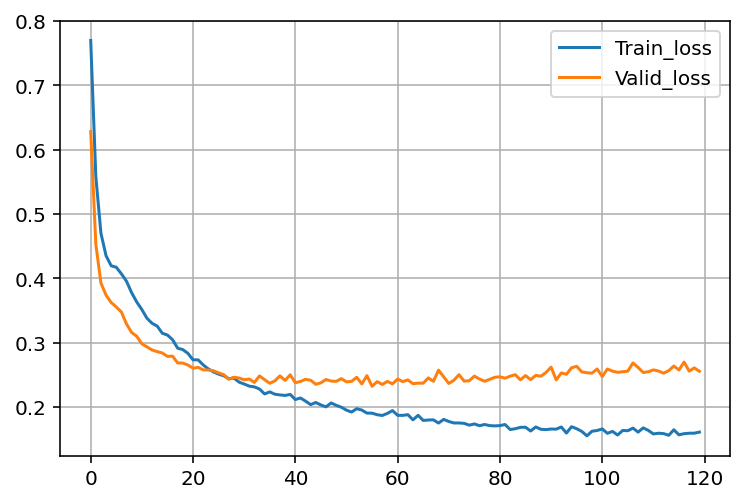

In [ ]:
plt.plot(my_MLP.loss_during_training,label='Train_loss')
plt.plot(my_MLP.valid_loss_during_training,label='Valid_loss')
plt.grid()
plt.legend()

Calculamos la salida para el conjunto de test (log-probabilidad por dato), y evaluamos métricas ...

In [ ]:
out_test = my_MLP.forward(torch.Tensor(W_[idx_test,:])).detach().numpy()

In [ ]:
# Accuracy en test

np.sum(np.argmax(out_test,1)==y_test)/np.shape(y_test)[0]

0.9256993006993007

In [ ]:
out_train = my_MLP.forward(torch.Tensor(W_[idx_train,:])).detach().numpy()

In [ ]:
# Accuracy en train

np.sum(np.argmax(out_train,1)==y_train)/np.shape(y_train)[0]

0.9393110989611809

Curvas ROC y PR ...

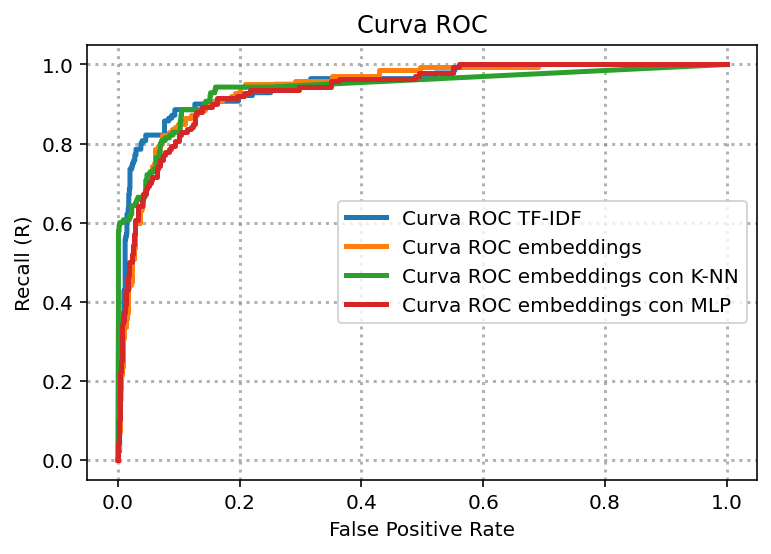

El área bajo la curva ROC de TF-IDF es 0.9480150825270348
El área bajo la curva ROC de embeddings es 0.9407441661923734
El área bajo la curva ROC de embeddings con K-NN es 0.9379553215708594
El área bajo la curva ROC de embeddings con MLP es 0.9352589641434262


In [ ]:
fpr4, recall4, thresholds = metrics.roc_curve(y_test, np.exp(out_test)[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC embeddings con K-NN')
plt.plot(fpr4,recall4,lw=2.5,label='Curva ROC embeddings con MLP')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_embbedings_MLP = metrics.roc_auc_score(y_test, np.exp(out_test)[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de embeddings con K-NN es {area_roc_embbedings_knn}")
print(f"El área bajo la curva ROC de embeddings con MLP es {area_roc_embbedings_MLP}")

Podemos comprobar cómo el nuevo clasificador no consigue una gran mejora con respecto a soluciones anteriores. 


## 6. Clasificación RNN + Regresión Logística

Finalmente, vamos a comprobar cómo un procesado secuencial de las palabras utilizando una RNN permite una representación vectorial del texto más fiel al contenido, permitiendo una mejora de las prestaciones del clasificador. Tanto es así, que el clasificador será una simple regresión logística sobre el último estado de la RNN.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=800 />


Primero, vamos a normalizar la longitud de las secuencias de texto. Esto es solo un requisito de entrada para la función RNN de pytorch. Una vez obtengamos la secuencia de estados de la RNN, **utilizaremos el estado resultante tras procesar la última palabra del texto**.

In [ ]:
# Calculamos la longitud por texto

longitudes = [len(d) for d in norm_docs]

# Máxima longitud
max_l = np.max(longitudes)

In [ ]:
max_l

35

In [ ]:
# Igualar dataset añadiendo un token "basura" (no se tendrá en cuenta)

garbage_token = nlp('#') # Token basura --> #

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-longitudes[d]) for d in range(len(norm_docs))]

# documentos train

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [longitudes[d] for d in idx_train]

# documentos validación

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [longitudes[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [longitudes[d] for d in idx_test]

A continuación creamos la clase RNN. A la hora de construir una RNN debemos especificar los siguientes parámetros

* **input_size** - En nuestro caso dimensión de cada word embedding (300)
* **hidden_dim** - La dimensión del estado de la LSTM
* **n_layers** - Número de **LSTMs apiladas**, tal y como se ilustra en la siguiente figura 
* **dropout** - Probabilidad de dropout entre capas (sólo si n_layers>1) 

<img src="https://yiyibooks.cn/__src__/wizard/nmt-tut-neubig-2017_20180721165003_deleted/img/6-5.jpg" width="40%"> 

Se aconseja ver la documentación oficial de la capa [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) para entender todos sus parámetros:

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):
        
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size
        
        # Capa LSTM
        # batch_first=True significa que la primera dimensión del tensor de entrada indexa datos distintos
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) 
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Capa dropout 
        
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        
        '''
        
        - x: secuencias de texto, codificadas con word embeddings. Dimensiones (batch_size, seq_length, input_size)
        - lengths: la longitud de cada texto (antes de meter el token de relleno). Se usa para mirar el estado correcto
          para clasificar.
        
        Sobre las dimensiones de los tensores de entrada ...:
        
        - Señal de entrada a RNN tiene dimensiones (batch_size, seq_length, input_size)
        - La inicialización del estado de la RNN tiene dimensiones (n_layers, batch_size, hidden_dim).
          Si se usa None, se inicializa con ceros.
        - La salida de la RNN tiene dimensiones (batch_size, seq_length, hidden_size). 
          Esta salida es el estado de la RNN a lo largo del tiempo para cada dato 

        '''
        
        batch_size = x.size(0) 
        seq_length = x.size(1) 
        
        # Calculamos la salida de la RNN
        # r_out es la secuencia de estados
        r_out, _ = self.rnn(x, h0)
        
        # Usamos el estado correspondiente a procesar la última palabra, antes de meter el relleno.
        # Con el reshape pasamos a dimensiones (batch_ize, hidden_dim)
        
        
        aux=torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        
        # Clasificamos usando una log-softmax
        
        output = self.logsoftmax(self.fc1(self.dropout(aux)))
    
        
        return output


Vamos a ilustrar cómo podemos obtener la salida de la red dados nuestros textos. Por ejemplo, obtengamos la salida de la RNN para los tres primeros textos. El primer paso es obtener las **secuencias de word embeddings** de cada uno de ellos ...

In [ ]:
idx = [1,2,3]
x_input = torch.Tensor([[w.vector for w in norm_docs_eq_length[d]] for d in idx])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
x_input.shape

torch.Size([3, 35, 300])

Instanciamos la clase anterior

In [ ]:
my_RNN = RNN(300,2,20,1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
o = my_RNN.forward(torch.Tensor(x_input),[longitudes[d] for d in idx])

In [ ]:
print(torch.exp(o))

tensor([[0.5011, 0.4989],
        [0.4323, 0.5677],
        [0.4198, 0.5802]], grad_fn=<ExpBackward0>)


Tal y como hicimos anteriormente, extendemos la clase para añadir un método de entrenamiento. El entrenamiento de RNNs puede ser lento, y se recomienda añadir funcionalidades para explotar hardware de tipo GPU. Un ejemplo puede encontrarse en este [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

Se han añadido funcionalidades para **salvar la configuración de la red al final de cada época durante el entrenamiento**. Esto nos permitirá recuperar la red que minimiza el error de validación.

In [ ]:
class RNN_with_train(RNN):
    
    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./RNN_sentiment_analysis'):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizador
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files
        
        
    def predict_proba(self,docs,lengths,Y=0):
        
        '''
        Este método lo usamos para obtener la salida de la red dado un conjunto de documentos. Si se proporciona etiqueta,
        obtenemos accuracy.
        
        - docs: documentos, en formato lista de spacy tokens. Normalizados con igual longitud añadiendo tokens basura
        - lengths: longitud real de cada texto.
        - Y: Etiquetas
        '''
        
        x_input = torch.Tensor([[w.vector for w in d] for d in docs])
        
        logprobs = self.forward(x_input,lengths).detach().numpy()
            
        accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy
            
        
    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):
        
        '''
        Método de entrenamiento.
        
        - docs_train, docs_val: documentos de training/validación (secuencias de spacy tokens). 
          Normalizados con igual longitud añadiendo tokens basura
        - len_train/len_val: longitudes reales
        '''
        
        self.print_every = print_every
        
        self.epochs=epochs
        
        # Optimization Loop
        
        self.num_train = len(docs_train) # Num datos de entrenamiento
        
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Numero de batches de training
        
        self.num_val = len(docs_val) # Num datos de validación
        
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero de batches de validación 
        
        labels = torch.Tensor(Y).type(torch.LongTensor) # Etiquetas training
        
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Etiquetas validación
        
        
        for e in range(int(self.epochs)):
            
            self.train() # Dropout activado
            
            # Permutación aleatoria datos
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
                        
                self.optim.zero_grad()  # Ponemos gradientes a cero

                # Ínidices de los datos que entran al batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # Codificamos entradas como secuencias de embeddings
                
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])
                
                # Calculamos probabilidades por dato

                out = self.forward(x_input,[len_train[d] for d in idx_batch])
                
                # Evaluamos función de coste

                loss = self.criterion(out,labels[idx_batch])
                
                # Guardamos para monitorizar

                running_loss += loss.item()
                
                # Calculamos gradientes

                loss.backward()

                # Limitamos el valor de los gradientes para evitar problemas numéricos (típicos en RNNs)
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
                # Iteración SGD
                
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # Guardamos los parámetros del modelo
            
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            
            # Repetimos para validación, pero sin evaluar gradientes
            
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)

                running_loss = 0.
                
                for i in range(int(self.num_batchs_val)):
                    
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    
                

            if(e % self.print_every == 0): 

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Definida la red neuronal y los métodos para su entrenamiento, instaciamos la clase y entrenamos. Utilizamos un estado de la LSTM de 20 dimensiones y una sóla capa LSTM, pero estos parámetro **no se han validado**. HAY MUCHO MARGEN DE MEJORA!

In [ ]:
my_RNN = RNN_with_train(input_size=300,output_size=2,hidden_dim=100,prob=0.6,n_layers=1)

In [ ]:
my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=30,print_every=1)

Training loss after 0 epochs: 0.3799971544171033. Validation loss: 0.2938723920120133
Training loss after 1 epochs: 0.2963907373686359. Validation loss: 0.26811562726895016
Training loss after 2 epochs: 0.2641533359068714. Validation loss: 0.24480930219093958
Training loss after 3 epochs: 0.22569609443618827. Validation loss: 0.23292133253481653
Training loss after 4 epochs: 0.1847418199663293. Validation loss: 0.20318900504046017
Training loss after 5 epochs: 0.1437195487422486. Validation loss: 0.18538373336195946
Training loss after 6 epochs: 0.11432617509814158. Validation loss: 0.17204478362368214
Training loss after 7 epochs: 0.09276911412199883. Validation loss: 0.17112873515321148
Training loss after 8 epochs: 0.07042963167473879. Validation loss: 0.15375197187273038
Training loss after 9 epochs: 0.050936631437340014. Validation loss: 0.15854421630501747
Training loss after 10 epochs: 0.032501799666820326. Validation loss: 0.15909825464607114
Training loss after 11 epochs: 0.02

Representamos la evolución de la función de coste en entrenamiento/validación ...

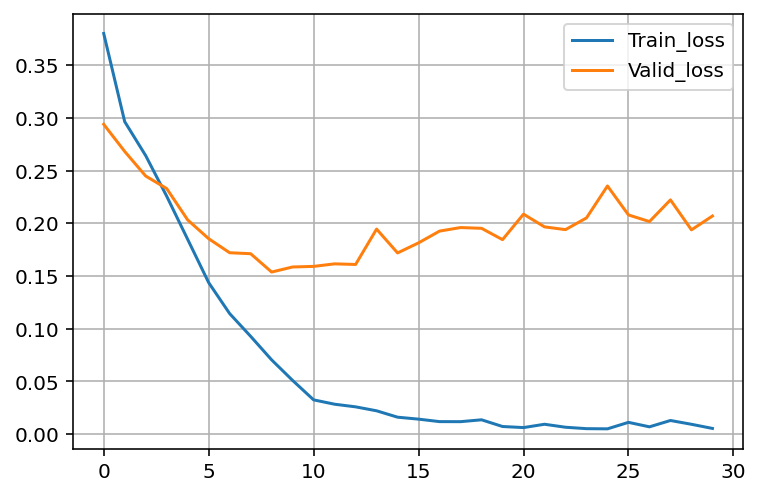

In [ ]:
plt.plot(my_RNN.loss_during_training,label='Train_loss')
plt.plot(my_RNN.valid_loss_during_training,label='Valid_loss')
plt.legend()
plt.grid()

Con el siguiente código, recuperamos los parámetros de la red que minimizan el error de validación ...

In [ ]:
# Época en la que se minimiza el error de validación

idx_min = np.argsort(my_RNN.valid_loss_during_training)

In [ ]:
idx_min[0]

8

Cargamos la red

In [ ]:
state_dict = torch.load(my_RNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth')

my_RNN.load_state_dict(state_dict)

<All keys matched successfully>

Calculamos el accuracy en test y las métricas ROC y curva PR ...

In [ ]:
probs,acc = my_RNN.predict_proba(docs_test,len_test,y_test)

probs = np.exp(probs)

In [ ]:
print(acc)

0.951048951048951


En términos de accuracy superamos a todos los modelos anteriores. 

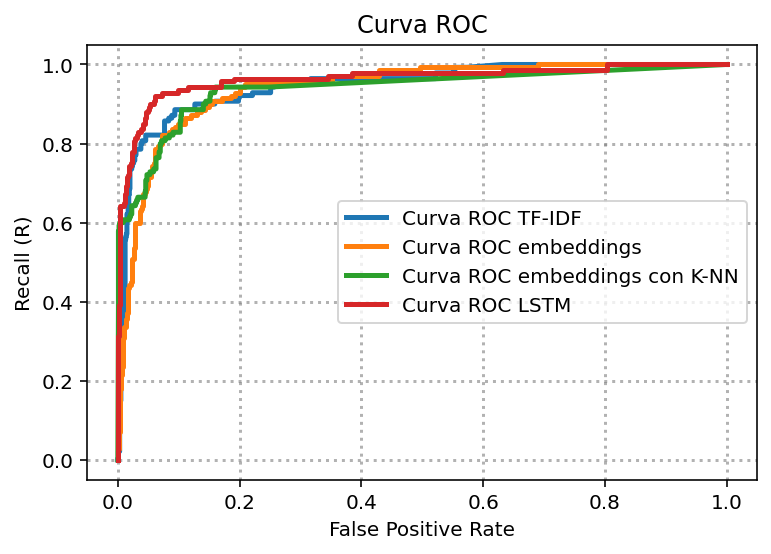

El área bajo la curva ROC de TF-IDF es 0.9480150825270348
El área bajo la curva ROC de embeddings es 0.9407441661923734
El área bajo la curva ROC de embeddings con K-NN es 0.9379553215708594
El área bajo la curva ROC de LSTM es 0.9637450199203187


In [ ]:
fpr4, recall4, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC TF-IDF')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC embeddings')
plt.plot(fpr3,recall3,lw=2.5,label='Curva ROC embeddings con K-NN')
plt.plot(fpr4,recall4,lw=2.5,label='Curva ROC LSTM')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_tf_idf = metrics.roc_auc_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_roc_embbedings = metrics.roc_auc_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_roc_embbedings_knn = metrics.roc_auc_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1])
area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"El área bajo la curva ROC de TF-IDF es {area_roc_tf_idf}")
print(f"El área bajo la curva ROC de embeddings es {area_roc_embbedings}")
print(f"El área bajo la curva ROC de embeddings con K-NN es {area_roc_embbedings_knn}")
print(f"El área bajo la curva ROC de LSTM es {area_roc_LSTM}")

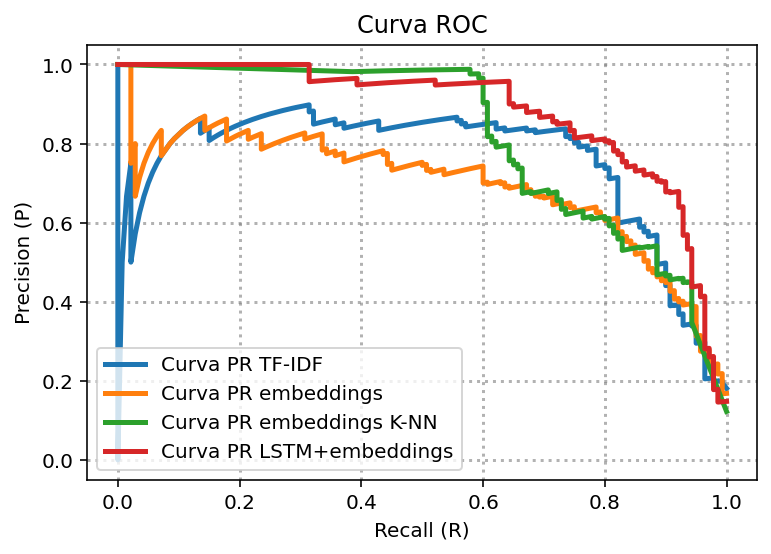

El área bajo la curva PR de TF-IDF es 0.7541924154560125
El área bajo la curva PR de embeddings es 0.6978537121812407
El área bajo la curva PR de embeddings con k-NN es 0.809433298791703
El área bajo la curva PR de embeddings con LSTM 0.8807013200617255


In [ ]:
P4, R4, thresholds = metrics.precision_recall_curve(y_test, probs[:,1], pos_label=1) 

fig,ax = plt.subplots()
plt.plot(R,P,lw=2.5,label='Curva PR TF-IDF')
plt.plot(R2,P2,lw=2.5,label='Curva PR embeddings')
plt.plot(R3,P3,lw=2.5,label='Curva PR embeddings K-NN')
plt.plot(R4,P4,lw=2.5,label='Curva PR LSTM+embeddings')
plt.legend(loc=3)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('Recall (R)')
plt.ylabel('Precision (P)')
plt.title('Curva PR')
plt.show()

area_pr_tf_idf = metrics.average_precision_score(y_test, LR_with_CV.predict_proba(C[idx_test,:])[:,1])
area_pr_embbedings = metrics.average_precision_score(y_test, emb_LR_with_CV.predict_proba(W_test)[:,1])
area_pr_embbedings_knn = metrics.average_precision_score(y_test, knn.predict_proba(W_[idx_test,:])[:,1], pos_label=1) 
area_pr_LSTM = metrics.average_precision_score(y_test, probs[:,1], pos_label=1) 

print(f"El área bajo la curva PR de TF-IDF es {area_pr_tf_idf}")
print(f"El área bajo la curva PR de embeddings es {area_pr_embbedings}")
print(f"El área bajo la curva PR de embeddings con k-NN es {area_pr_embbedings_knn}")
print(f"El área bajo la curva PR de embeddings con LSTM {area_pr_LSTM}")

La mejora es evidente sobre todo a la vista de la curva PR.

Es interesante mostrar ejemplos de frases en las que el mejor método hasta ahora (k-NN con medias de word embeddings) falla y el método con LSTMs no. 

In [ ]:
errores_LSTM = np.where(np.argmax(probs,1)!=y_test)[0]

In [ ]:
len(errores_LSTM)

56

In [ ]:
len(errores_k_NN)

79

Podemos ver cómo para un umbral de decisión de 0.5, con LSTMs tenemos 26 fallos menos que con un k-NN con medias de word embeddings.

In [ ]:
errores_LSTM

array([  23,   41,   47,   64,  105,  128,  142,  145,  159,  163,  231,
        239,  282,  406,  413,  415,  444,  449,  455,  477,  550,  552,
        594,  603,  623,  624,  642,  654,  662,  677,  678,  683,  686,
        716,  736,  762,  772,  777,  790,  823,  830,  837,  857,  879,
        883,  906,  937,  967,  988, 1014, 1041, 1049, 1070, 1097, 1129,
       1130])

In [ ]:
errores_k_NN

array([   9,   37,   65,   86,  105,  119,  128,  142,  145,  163,  169,
        172,  190,  206,  208,  210,  218,  224,  239,  265,  278,  282,
        334,  336,  348,  374,  377,  384,  385,  406,  415,  417,  442,
        449,  452,  455,  464,  477,  488,  505,  511,  550,  552,  574,
        594,  605,  614,  623,  624,  640,  642,  662,  668,  677,  683,
        686,  700,  707,  718,  737,  739,  772,  777,  790,  823,  837,
        871,  883,  893,  913,  930,  937,  967,  989, 1001, 1014, 1022,
       1045, 1097])

Imprimamos una de las frases en las que k-NN falla ...

In [ ]:

i = 105

df.iloc[idx_test[i]]['Phrase']

'The company reports a loss for the period of EUR 0.4 mn compared to a loss of EUR 1.9 mn in the corresponding period in 2005 .'

In [ ]:
y_test[i]

0

La anterior frase tiene etiqueta 0 (positiva/neutral). **Sin embargo k-NN falla ya que no considera el orden de las palabras y, desde el punto de vista de un BoW, hay muchas palabras negativas!!**

In [ ]:
knn.predict_proba(W_[idx_test[i],:].reshape([1,-1]))

array([[0.33524893, 0.66475107]])

Sin embargo, el procesado secuencial de LSTM sí permite clasificar correctamente esta frase ...

In [ ]:
probs[i]

array([0.13711166, 0.8628883 ], dtype=float32)

## 7. Clasificación multi-clase

Finalmente, vamos a ilustrar cómo en el caso de clasificación multi-clase, usando las tres etiquetas originales, de nuevo WE + LSTMs + Regresión Logística alcanza el mejor resultado ...

In [ ]:
# Separamos train de test
idx_train, idx_test, y_train_multiclass, y_test_multiclass = train_test_split(idx_data, labels, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train_multiclass, y_val_multiclass = train_test_split(idx_train, y_train_multiclass, test_size=0.2, random_state=0)

rango_C = np.logspace(-3, 3, 20)  # Rango C en escala logarítmica (base 10). Esto es, 20 puntos desde 10^3, a 10^3.
diccionario_parametros = [{'C': rango_C}]   
nfold = 10 # Número de particiones train/validación

""" Ajusto C por validación cruzada
El optimizador por defecto ('lbfgs') no acepta regularización l1. 
Usamos 'liblinear' siguiendo las recomendaciones de la librería.
"""
LR_with_CV  = GridSearchCV(estimator=LR(penalty='l1',max_iter=1e08,solver='liblinear'),
                                  param_grid=diccionario_parametros,cv=nfold)
# Entrenar el modelo
LR_with_CV.fit(C[idx_train,:],y_train_multiclass)   

print("El mejor parámetro C es {0:.2f}".format(LR_with_CV.best_params_['C']))
                        
# Score de claisficación en train/test
accuracy_train = LR_with_CV.score(C[idx_train,:],y_train_multiclass)   
accuracy_test = LR_with_CV.score(C[idx_test,:],y_test_multiclass)  

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train*100, accuracy_test*100))

El mejor parámetro C es 12.74
Accuracy train 99.13%. Accuracy test 89.25%



In [ ]:
# Entrenamiento k-NN con validación de vecinos y ponderación de distancias
K_max = 15
rango_K = np.arange(1, K_max+1)
nfold = 10
# Define a dictionary with the name of the parameters to explore as a key and the ranges to explores as value
diccionario_parametros = [{'n_neighbors': rango_K,'weights':['uniform','distance']}]

# Validación cruzada con GridSearchCV
knn = GridSearchCV(estimator=KNeighborsClassifier( ), param_grid=diccionario_parametros,cv=nfold)
# Entrenamiento
knn.fit(W_[idx_train,:],y_train_multiclass)
# Test
accuracy_train_knn = knn.score(W_[idx_train,:],y_train_multiclass)
accuracy_test_knn = knn.score(W_[idx_test,:],y_test_multiclass)

print("El número de vecinos seleccionado es k={0:d}".format(knn.best_params_['n_neighbors']))
print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%\n".format(accuracy_train_knn*100, accuracy_test_knn*100))

El número de vecinos seleccionado es k=9
Accuracy train 100.00%. Accuracy test 85.23%



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Matrix confusión, codificación embeddings')

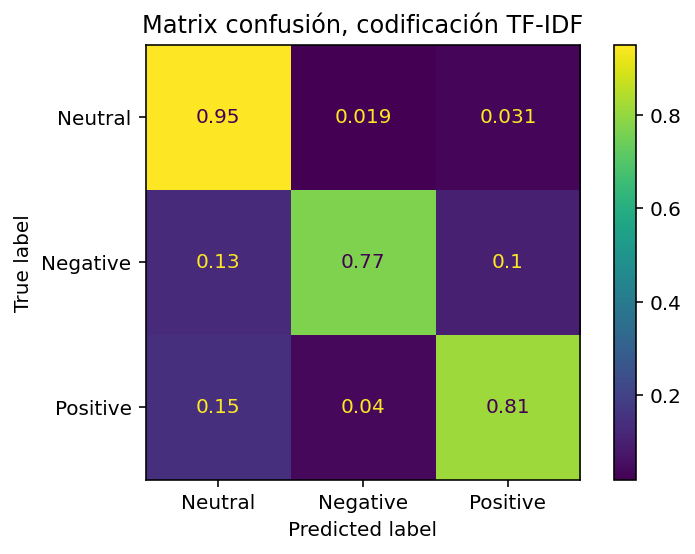

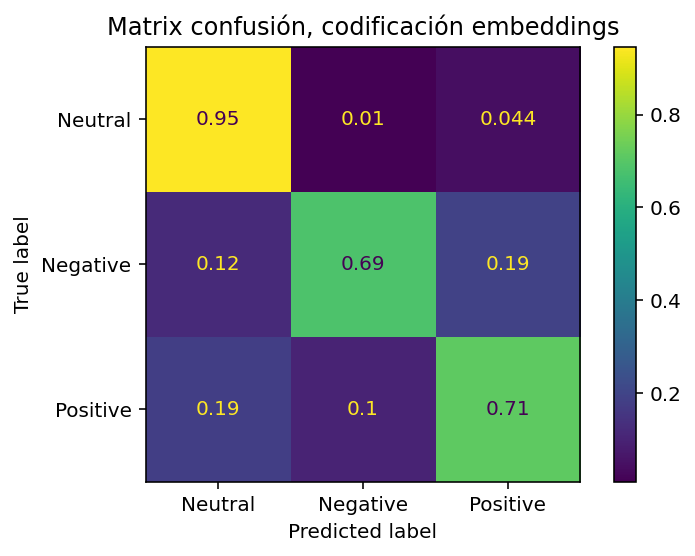

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(LR_with_CV, C[idx_test,:], y_test_multiclass,normalize='true',display_labels=['Neutral','Negative','Positive'])
plt.title('Matrix confusión, codificación TF-IDF')

plot_confusion_matrix(knn, W_[idx_test,:], y_test_multiclass,normalize='true',display_labels=['Neutral','Negative','Positive'])
plt.title('Matrix confusión, codificación embeddings')

In [ ]:
docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [longitudes[d] for d in idx_train]

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [longitudes[d] for d in idx_val]

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [longitudes[d] for d in idx_test]

Reultizamos la clase `RNN_with_train` que construímos anteriormente, especificando ahora `output_size=3`, puesto que tenemos tres etiquetas ...

In [ ]:
my_RNN_3_class = RNN_with_train(input_size=300,output_size=3,hidden_dim=100,n_layers=1,saved_files='./RNN_sentiment_analysis_multiclass',prob=0.6)

In [ ]:
my_RNN_3_class.fit(docs_train,docs_val,torch.Tensor(y_train_multiclass),torch.Tensor(y_val_multiclass),len_train,len_val,epochs=20,print_every=2)

Training loss after 0 epochs: 0.8505171684369649. Validation loss: 0.7049986024697622
Training loss after 2 epochs: 0.5953823136140223. Validation loss: 0.5556424823072221
Training loss after 4 epochs: 0.43260574626596004. Validation loss: 0.43210895359516144
Training loss after 6 epochs: 0.29674035392395437. Validation loss: 0.35379651106066173
Training loss after 8 epochs: 0.18292473108597. Validation loss: 0.29770176857709885
Training loss after 10 epochs: 0.12597007151335887. Validation loss: 0.30303799899088013
Training loss after 12 epochs: 0.08948018090569809. Validation loss: 0.31474438309669495
Training loss after 14 epochs: 0.054938469936892595. Validation loss: 0.29411965794861317
Training loss after 16 epochs: 0.052365851499242326. Validation loss: 0.3062153880794843
Training loss after 18 epochs: 0.024011162441376955. Validation loss: 0.3511207592156198


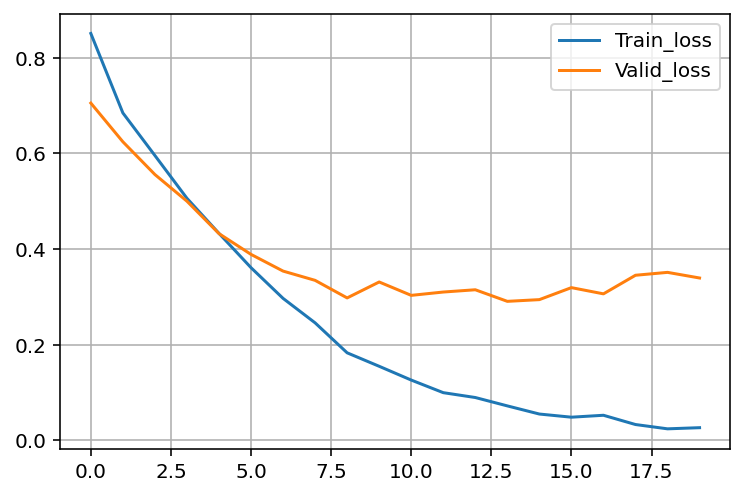

In [ ]:
plt.plot(my_RNN_3_class.loss_during_training,label='Train_loss')
plt.plot(my_RNN_3_class.valid_loss_during_training,label='Valid_loss')
plt.grid()
plt.legend()

Recuperamos la red en el mínimo de la función de coste en validación ...

In [ ]:
idx_min = np.argsort(my_RNN_3_class.valid_loss_during_training)

In [ ]:
idx_min[0]

13

In [ ]:
state_dict = torch.load(my_RNN_3_class.saved_files+'_epoch_'+str(idx_min[0])+'.pth')

my_RNN_3_class.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
probs,acc = my_RNN_3_class.predict_proba(docs_test,len_test,y_test_multiclass)

In [ ]:
print(acc)

0.8986013986013986


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_multiclass, np.argmax(probs,1))

cm /np.sum(cm,1)

array([[0.96723647, 0.05714286, 0.04966887],
       [0.02136752, 0.82857143, 0.02980132],
       [0.05698006, 0.20714286, 0.77152318]])